Load all images from `input/`, rescaling to max 500x500px and converting to grayscale.

In [109]:
%pylab inline
from IPython.display import Image, display
import PIL.Image
import matplotlib.image as mpimg
import scipy.ndimage
import cv2 # For Sobel etc
import glob
np.set_printoptions(suppress=True, linewidth=200) # Better printing of arrays
plt.rcParams['image.cmap'] = 'jet' # Default colormap is jet

Populating the interactive namespace from numpy and matplotlib


In [110]:
filenames = glob.glob('input/*')
print(len(filenames))

19


In [111]:
from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread

# hSize = 20
# wSize = 15
col = 4

def showImagesMatrix(image_arr, col=10, cmap_='Greys_r', wSize=15, hSize=20):
    fig = figure( figsize=(wSize, hSize))
    n = len(image_arr)
    row = n/col
    if (n%col != 0):
        row += 1
    for i in range(n):
        a=fig.add_subplot(row,col,i+1)
        image = image_arr[i]
        imshow(image, cmap=cmap_)
        axis('off')

In [270]:
# Load all images (after rescaling and grayscale)
img_arr = []
for i in range(len(filenames)):
    filename = filenames[i]

    img_orig = PIL.Image.open(filename)
    img_width, img_height = img_orig.size

    # Resize
    aspect_ratio = min(500.0/img_width, 500.0/img_height)
    new_width, new_height = ((np.array(img_orig.size) * aspect_ratio)).astype(int)
    img = img_orig.resize((new_width,new_height), resample=PIL.Image.BILINEAR)
    img = img.convert('L') # grayscale
    img = np.array(img)
    img = cv2.blur(img, (3,3)) # Blur it
    img_arr.append(img)

# showImagesMatrix(img_arr,col)

In [113]:
grad_mags = []
grad_phases = []

for img in img_arr:
    # img = img_arr[20]

    gx = cv2.Sobel(img,cv2.CV_64F,1,0)
    gy = cv2.Sobel(img,cv2.CV_64F,0,1)

    grad_mag = gx*gx+gy*gy
    grad_phase = np.arctan2(gy, gx) # from -pi to pi
    grad_phase_masked = grad_phase.copy()
    gradient_mask_threshold = 2*np.mean(grad_mag.flatten())
    grad_phase_masked[grad_mag < gradient_mask_threshold] = np.nan

#     figure( figsize=(15, 15))
    # imshow(grad_mag, cmap='Greys_r')
    # imshow(grad_phase_masked)
    grad_mags.append(grad_mag)
    grad_phases.append(grad_phase_masked)
    

In [269]:
# showImagesMatrix(grad_mags, col=5, cmap_='Greys_r')

In [268]:
# showImagesMatrix(grad_phases, col=5, cmap_='jet')

Saddle detect http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.87.5833&rep=rep1&type=pdf 

In [116]:
def getSaddle(gray_img):
    img = gray_img.astype(np.float64)
    gx = cv2.Sobel(img,cv2.CV_64F,1,0)
    gy = cv2.Sobel(img,cv2.CV_64F,0,1)
    gxx = cv2.Sobel(gx,cv2.CV_64F,1,0)
    gyy = cv2.Sobel(gy,cv2.CV_64F,0,1)
    gxy = cv2.Sobel(gx,cv2.CV_64F,0,1)
    
    S = gxx*gyy - gxy**2
    return S

In [194]:
def nonmax_sup(img, win=10):
    w, h = img.shape
#     img = cv2.blur(img, ksize=(5,5))
    img_sup = np.zeros_like(img, dtype=np.float64)
    for i,j in np.argwhere(img):
        # Get neigborhood
        ta=max(0,i-win)
        tb=min(w,i+win+1)
        tc=max(0,j-win)
        td=min(h,j+win+1)
        cell = img[ta:tb,tc:td]
        val = img[i,j]
        if np.sum(cell.max() == cell) > 1:
            print(cell.argmax())
        if cell.max() == val:
            img_sup[i,j] = val
    return img_sup

In [267]:
i = 5
s = saddles[i].copy()
s2 = nonmax_sup(s)
print(np.sum(s2!=0))
pts = np.argwhere(s2!=0)
# print(pts)

# figure(figsize=(20,20))
# plt.grid()
# imshow(img_arr[i], cmap='Greys_r', interpolation='None')
# plt.plot(pts[:,1], pts[:,0], 'o')


154


In [117]:
def pruneSaddle(s):
    thresh = 128
    score = (s>0).sum()
    while (score > 10000):
        thresh = thresh*2
        s[s<thresh] = 0
        score = (s>0).sum()

In [118]:
saddles = []
for img in img_arr:
#     img = img_arr[20]

    saddle = getSaddle(img)
    saddle = -saddle
    saddle[saddle<0] = 0
    
    pruneSaddle(saddle)

    saddles.append(saddle)
#     figure( figsize=(15, 15))
    # imshow(saddle, cmap='Greys_r')
    # imshow(grad_phase_masked)


In [266]:
# showImagesMatrix(saddles, col=5)

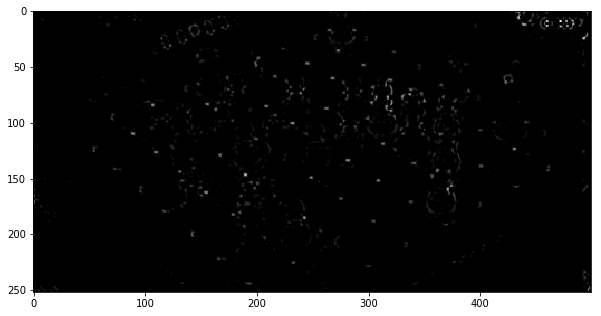

In [120]:
s = saddles[0].copy()
   
plt.figure(figsize=(10,10))
imshow(s,  cmap='Greys_r')
# plt.hist(s[:])

In [121]:
def simplifyContours(contours):
  for i in range(len(contours)):
    # Approximate contour and update in place
    contours[i] = cv2.approxPolyDP(contours[i],0.04*cv2.arcLength(contours[i],True),True)

def is_square(cnt, eps=3.0, xratio_thresh = 0.5):
  # 4x2 array, rows are each point, columns are x and y
  center = cnt.sum(axis=0)/4

  # Side lengths of rectangular contour
  dd0 = np.sqrt(((cnt[0,:] - cnt[1,:])**2).sum())
  dd1 = np.sqrt(((cnt[1,:] - cnt[2,:])**2).sum())
  dd2 = np.sqrt(((cnt[2,:] - cnt[3,:])**2).sum())
  dd3 = np.sqrt(((cnt[3,:] - cnt[0,:])**2).sum())

  # diagonal ratio
  xa = np.sqrt(((cnt[0,:] - cnt[2,:])**2).sum())
  xb = np.sqrt(((cnt[1,:] - cnt[3,:])**2).sum())
  xratio = xa/xb if xa < xb else xb/xa

  # Check whether all points part of convex hull
  # ie. not this http://i.stack.imgur.com/I6yJY.png
  # all corner angles, angles are less than 180 deg, so not necessarily internal angles
  ta = getAngle(dd3, dd0, xb) 
  tb = getAngle(dd0, dd1, xa)
  tc = getAngle(dd1, dd2, xb)
  td = getAngle(dd2, dd3, xa)
  angle_sum = np.round(ta+tb+tc+td)

  is_convex = np.abs(angle_sum - 360) < 5

  angles = np.array([ta,tb,tc,td])
  good_angles = np.all((angles > 40) & (angles < 140))


  # side ratios
  dda = dd0 / dd1
  if dda < 1:
    dda = 1. / dda
  ddb = dd1 / dd2
  if ddb < 1:
    ddb = 1. / ddb
  ddc = dd2 / dd3
  if ddc < 1:
    ddc = 1. / ddc
  ddd = dd3 / dd0
  if ddd < 1:
    ddd = 1. / ddd
  side_ratios = np.array([dda,ddb,ddc,ddd])
  good_side_ratios = np.all(side_ratios < eps)

  # Return whether side ratios within certain ratio < epsilon
  return (
    # abs(1.0 - dda) < eps and 
    # abs(1.0 - ddb) < eps and
    # xratio > xratio_thresh and 
    # good_side_ratios and
    # is_convex and
    good_angles)
    
def getAngle(a,b,c):
  # Get angle given 3 side lengths, in degrees
  k = (a*a+b*b-c*c) / (2*a*b)
  # Handle floating point errors
  if (k < -1):
    k=-1
  elif k > 1:
    k=1
  return np.arccos(k) * 180.0 / np.pi

def pruneContours(contours, hierarchy, saddle):
  new_contours = []
  new_hierarchies = []
  for i in range(len(contours)):
    cnt = contours[i]
    h = hierarchy[i]
    
    # Must be child
    if h[2] != -1:
        continue
    
    # Only rectangular contours allowed
    if len(cnt) != 4:
      continue
        
    # Only contours that fill an area of at least 8x8 pixels
    if cv2.contourArea(cnt) < 8*8:
      continue

    if not is_square(cnt):
      continue
    
    # TODO : Remove those where internal luma variance is greater than threshold
    
    cnt = updateCorners(cnt, saddle)
    # If not all saddle corners
    if len(cnt) != 4:
        continue

    new_contours.append(cnt)
    new_hierarchies.append(h)
  new_contours = np.array(new_contours)
  new_hierarchy = np.array(new_hierarchies)
  if len(new_contours) == 0:
    return new_contours, new_hierarchy
  
#   norm_contours = new_contours[:,:,0,:] - new_contours[:,[0],0,:]
#   median_contour = np.median(norm_contours, axis=0).astype(int)
#   diff = np.sqrt(np.sum((norm_contours - median_contour)**2,axis=2))

#   mask=np.all(diff < 60, axis=1)
# #   print(mask.shape)
#   new_contours = new_contours[mask]
#   new_hierarchy = new_hierarchy[mask]

  # Prune contours below median area
  areas = [cv2.contourArea(c) for c in new_contours]
  mask = [areas >= np.median(areas)*0.25] and [areas <= np.median(areas)*2.0]
  new_contours = new_contours[mask]
  new_hierarchy = new_hierarchy[mask]
  return np.array(new_contours), np.array(new_hierarchy)


In [122]:
def getContours(img, edges, iters=10):
    # Morphological Gradient to get internal squares of canny edges. 
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
    edges_gradient = cv2.morphologyEx(edges, cv2.MORPH_GRADIENT, kernel)
    _, contours, hierarchy = cv2.findContours(edges_gradient, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
    
    simplifyContours(contours)  
    
    return np.array(contours), hierarchy[0]


In [265]:
def updateCorners(contour, saddle):
#     print(contour)
    ws = 4 # half window size (+1)
    new_contour = contour.copy()
    for i in range(len(contour)):
#         print(i, contour[i,0,:])
        cc,rr = contour[i,0,:]
        rl = max(0,rr-ws)
        cl = max(0,cc-ws)
        window = saddle[rl:min(saddle.shape[0],rr+ws+1),cl:min(saddle.shape[1],cc+ws+1)]
#         window = saddle[rr-ws:rr+ws+1,cc-ws:cc+ws+1]
#         print(window.astype(np.int)/1000)
        br, bc = np.unravel_index(window.argmax(), window.shape)
        s_score = window[br,bc]
        br -= min(ws,rl)
        bc -= min(ws,cl)
#         print(s_score, br, bc)
        if s_score > 0:
            new_contour[i,0,:] = cc+bc,rr+br
        else:
#             print("no saddle")
            return []
    return new_contour
        

img = img_arr[6].copy()
s = saddles[6]
edges = cv2.Canny(img, 20, 250)

contours_all, hierarchy = getContours(img,edges)

contours, hierarchy = pruneContours(contours_all, hierarchy, s)

c = contours[2]
c2 = updateCorners(c, s)
# print(c2)

plt.figure(figsize=(10,10))
img = img / 2
# cv2.drawContours(img,[c],-1,155,-1) # Fill mask with 1's inside contour
# img[saddle!=0] /= 2
cv2.drawContours(img,[c2],-1,255,-1) # Fill mask with 1's inside contour
# imshow(img, cmap='Greys_r');

array([[19, 19, 20, ..., 20, 20, 20],
       [17, 17, 18, ..., 20, 20, 20],
       [13, 13, 14, ..., 20, 20, 19],
       ..., 
       [33, 32, 22, ..., 12, 12, 12],
       [32, 33, 24, ..., 11, 11, 11],
       [35, 37, 25, ..., 11, 11, 11]], dtype=uint8)

In [264]:
print(c)
cc,rr = c[0,0,:]
plt.figure(figsize=(30,30))
# imshow(img[rr-15:rr+16,cc-15:cc+16], cmap='Greys_r');

[[[336 217]]

 [[362 220]]

 [[365 240]]

 [[338 237]]]


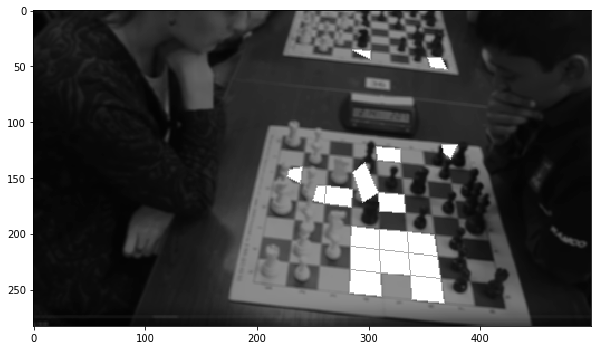

In [125]:
img = img_arr[6].copy()
s = saddles[6]
edges = cv2.Canny(img, 20, 250)



contours_all, hierarchy = getContours(img,edges)

contours, hierarchy = pruneContours(contours_all, hierarchy, s)
# print(contours.shape)
# print(contours.tolist())
plt.figure(figsize=(10,10))
img = img / 2
# cv2.drawContours(img,contours_all,-1,150,3) # Fill mask with 1's inside contour
cv2.drawContours(img,contours,-1,255,-1) # Fill mask with 1's inside contour
cv2.drawContours(img,contours,-1,150,0) # Fill mask with 1's inside contour
# for i in range(len(contours)):
#     cv2.putText(img, '%d' % i, (contours[i,0,0,0], contours[i,0,0,1]-6), cv2.FONT_HERSHEY_SIMPLEX, 0.5, 255)
imshow(img, cmap='Greys_r');

In [263]:
annotated_imgs = []
for i, img in enumerate(img_arr):
    edges = cv2.Canny(img, 20, 250)
    s = saddles[i]

    contours_all, hierarchy = getContours(img,edges)
    contours, hierarchy = pruneContours(contours_all, hierarchy, s)

    img = img / 2
    cv2.drawContours(img,contours,-1,255,-1) # Fill mask with 1's inside contour
    cv2.drawContours(img,contours,-1,150,0) # Outline
    annotated_imgs.append(img)

# showImagesMatrix(annotated_imgs, col=5, wSize=30, hSize=40)

In [129]:
adj_arr = []
for iii in range(len(img_arr)):
#     i = 3
    img=img_arr[iii].copy()
#     plt.figure(figsize=(10,10))

    edges = cv2.Canny(img, 20, 250)
    s = saddles[iii]

    contours_all, hierarchy = getContours(img,edges)
    contours, hierarchy = pruneContours(contours_all, hierarchy, s)


    cnts = contours.squeeze().copy()

    N = len(cnts)
    adj_mtx = np.zeros([N,N],dtype=np.int)

    matches = {}
    for i in range(N):
        for k in range(4):
            pt = cnts[i,k,:]
            key = "%d_%d" % (pt[0],pt[1])
            if matches.has_key(key):
                matches[key].append(i)
            else:
                matches[key] = [i]
    #         matches[] 

    # print(matches.values())

    for adj_set in matches.values():
        if len(adj_set) > 1:
    #         print(adj_set)
            for i in range(len(adj_set)-1):
                for j in range(i+1,len(adj_set)):
                    adj_mtx[adj_set[i],adj_set[j]] += 1


    # View
    img = img / 2
    cv2.drawContours(img,contours,-1,190,-1) # Fill mask with 1's inside contour
    cv2.drawContours(img,contours,-1,150,0) # Outline

    for i,j in np.argwhere(adj_mtx):
    #     print(i,j, adj_mtx[i,j])
        cnt_a = contours[i]
        cnt_b = contours[j]
        cnt_a_ctr = cnt_a[:,0,:].sum(axis=0) / 4
        cnt_b_ctr = cnt_b[:,0,:].sum(axis=0) / 4

        line_str = 55 + adj_mtx[i,j] * 100
        cv2.line(img, tuple(cnt_a_ctr), tuple(cnt_b_ctr), line_str,2)
    
    adj_arr.append(img)




# imshow(img, cmap='Greys_r');

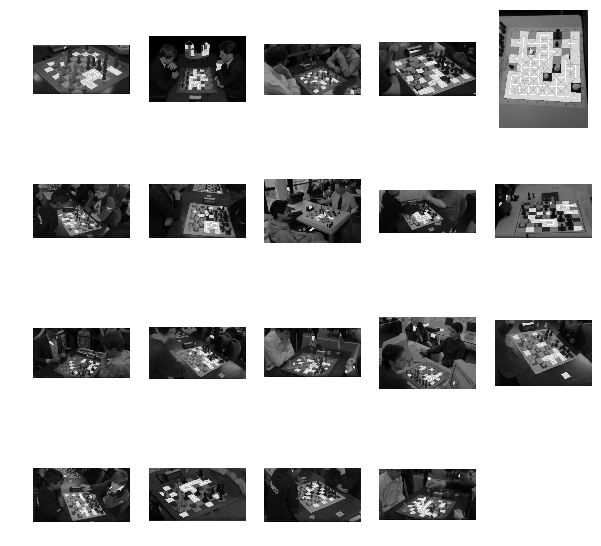

In [262]:
showImagesMatrix(adj_arr, col=5, wSize=10, hSize=10)

In [271]:
img = img_arr[6].copy()
s = saddles[6]
edges = cv2.Canny(img, 20, 250)



contours_all, hierarchy = getContours(img,edges)

contours, hierarchy = pruneContours(contours_all, hierarchy, s)
# print(contours.shape)
# print(contours.tolist())
img = img / 2

cnt_i = 0

cnt = contours[cnt_i].squeeze()
print(cnt)
da = cnt[1,:]-cnt[0,:]
db = cnt[2,:]-cnt[1,:]
dc = cnt[3,:]-cnt[2,:]
dd = cnt[0,:]-cnt[3,:]
# cnt += -db*3
cnt2 = cnt.copy()
cnt2[3,:] = cnt[0,:]
cnt2[2,:] = cnt[1,:]
cnt2[0,:] = cnt[0,:] + dd*5
cnt2[1,:] = cnt[1,:] - db*5

cv2.drawContours(img,[cnt],-1,255,-1) # Fill mask with 1's inside contour
cv2.drawContours(img,[cnt],-1,150,0) # Fill mask with 1's inside contour

cv2.drawContours(img,[cnt2],-1,255,-1) # Fill mask with 1's inside contour
cv2.drawContours(img,[cnt2],-1,150,0) # Fill mask with 1's inside contour

plt.figure(figsize=(20,10))
# imshow(img, cmap='Greys_r');

[[338 237]
 [365 240]
 [368 262]
 [339 259]]


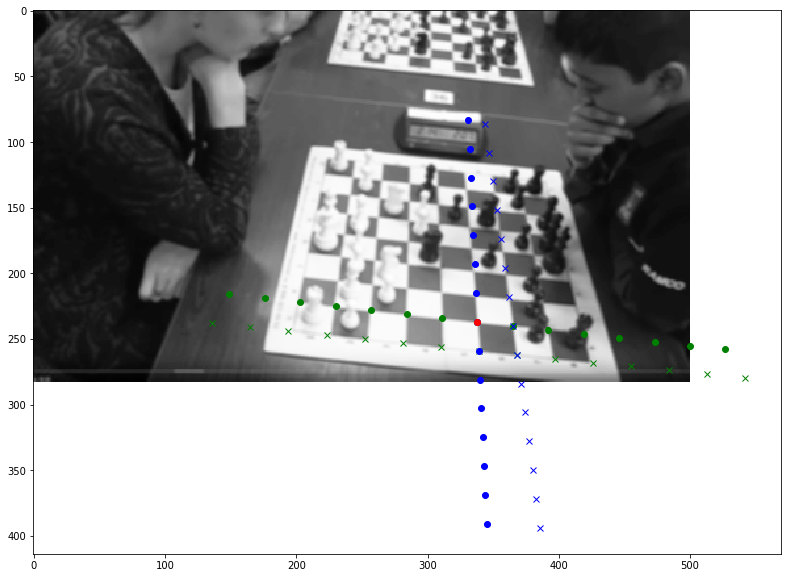

In [253]:
img = img_arr[6].copy()
s = saddles[6]
edges = cv2.Canny(img, 20, 250)



contours_all, hierarchy = getContours(img,edges)

contours, hierarchy = pruneContours(contours_all, hierarchy, s)
# print(contours.shape)
# print(contours.tolist())
img = img / 2

cnt_i = 0

cnt = contours[cnt_i].squeeze()
# print(cnt)
da = cnt[1,:]-cnt[0,:]
db = cnt[2,:]-cnt[1,:]
dc = cnt[3,:]-cnt[2,:]
dd = cnt[0,:]-cnt[3,:]

# 0 da 1
# dd   db
# 3 dc 2

p0 = cnt[0,:]
p1 = cnt[1,:]
p2 = cnt[2,:]
p3 = cnt[3,:]
pA = np.matrix(p0).T + np.matrix(da).T * np.arange(-7,8) # horz 1
pA2 = np.matrix(p3).T + np.matrix(dc).T * np.arange(-7,8) # horz 2

# vert
pB = np.matrix(p0).T + np.matrix(dd).T * np.arange(-7,8)
pB2 = np.matrix(p1).T + np.matrix(db).T * np.arange(-7,8)
# cnt += -db*3
# cnt2 = cnt.copy()
# cnt2[3,:] = cnt[0,:]
# cnt2[2,:] = cnt[1,:]
# cnt2[0,:] = cnt[0,:] + dd*5
# cnt2[1,:] = cnt[1,:] - db*5


plt.figure(figsize=(20,10))
imshow(img, cmap='Greys_r');
plt.plot(pA[0,:], pA[1,:], 'og')
plt.plot(pA2[0,:], pA2[1,:], 'xg')
plt.plot(pB[0,:], pB[1,:], 'ob')
plt.plot(pB2[0,:], pB2[1,:], 'xb')
plt.plot(p0[0], p0[1], 'or')

Idea 1 - Choose random tile, splay out all points, ICP to 9x9 with strongest saddle scores
Idea 2 - For all tiles, splay out all points, keep points that overlap within error and/or near saddle
Idea 3 - self-organizing map, use 9x9 grid of points with initial shape from random tile. The overall energy then is the deviation from this shape, for each saddle peak (randomly N times) pull closest point, pull other points elastically.
Idea 4 - Choose random tile, brute force all 9x9 grids, score each based on closest saddle per each (up to max), keep the min scoring one.

144


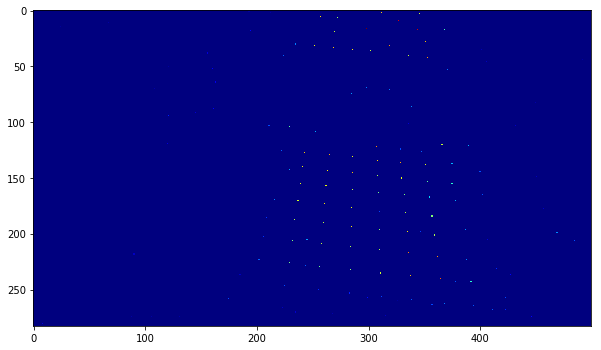

In [258]:
img = img_arr[6].copy()
s = saddles[6]
s2 = nonmax_sup(s)
figure(figsize=(10,10))
imshow(s2)

144


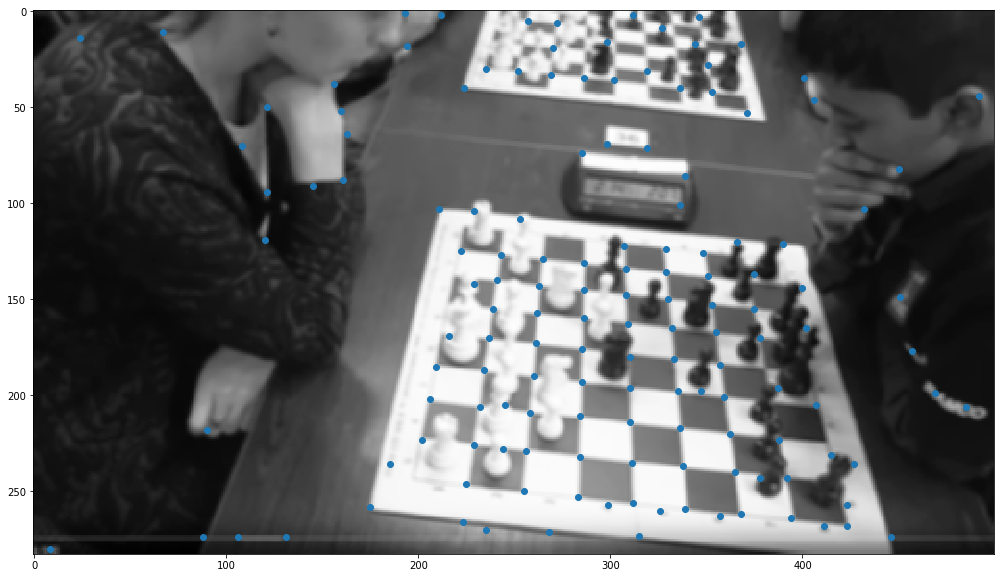

In [261]:
print(np.sum(s2!=0))
spts = np.argwhere(s2)
plt.figure(figsize=(20,10))
imshow(img, cmap='Greys_r');
plt.plot(spts[:,1],spts[:,0],'o')
